<a href="https://colab.research.google.com/github/mahimathakkar1124/COVID-19-Research-Paper-Text-Summarization/blob/main/Data606_UIDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install tika
!pip install PyPDF2
!pip install pytextrank
!pip install spacy && python -m spacy download en_core_web_sm
!pip install PyMuPDF
!pip install fitz

2021-03-04 01:32:56.203139: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
import pandas as pd 
from glob import glob
from tika import parser # pip install tika
import re
import string
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
import pytextrank
import numpy as np
import os
import ipywidgets as widgets
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.summarization import keywords, mz_keywords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from google.colab import drive
drive.mount('/content/gdrive/')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [6]:
fileContent={}
for file1 in glob(f"/content/gdrive/My Drive/Data 606/*.pdf"):
  print(file1)
  raw = parser.from_file(file1)
  title=''
  #fileContent.append(raw['content'])
  #print(raw['content'])
  if 'dc:title' in raw['metadata'].keys():
    #print(raw['metadata']['dc:title'])
    title=raw['metadata']['dc:title']
  else:
    #continue
    title=os.path.basename(file1)
  fileContent[os.path.basename(file1)]={'Title': title , 'Content': raw['content']}
  


/content/gdrive/My Drive/Data 606/1-s2.0-S2352827321000264-main.pdf
/content/gdrive/My Drive/Data 606/1-s2.0-S2213671121000886-main.pdf
/content/gdrive/My Drive/Data 606/1-s2.0-S2213671121000904-main.pdf
/content/gdrive/My Drive/Data 606/1-s2.0-S1517758021000023-main.pdf
/content/gdrive/My Drive/Data 606/1-s2.0-S1876201821000575-main.pdf
/content/gdrive/My Drive/Data 606/1-s2.0-S0378111921000901-main.pdf
/content/gdrive/My Drive/Data 606/1-s2.0-S0223523421001434-main.pdf
/content/gdrive/My Drive/Data 606/1-s2.0-S1018364721000276-main.pdf
/content/gdrive/My Drive/Data 606/1-s2.0-S2667147621000273-main.pdf
/content/gdrive/My Drive/Data 606/1-s2.0-S0020653921000368-main.pdf
/content/gdrive/My Drive/Data 606/1-s2.0-S241464472100004X-main.pdf
/content/gdrive/My Drive/Data 606/1-s2.0-S2667147621000182-main.pdf
/content/gdrive/My Drive/Data 606/1-s2.0-S0196655321000614-main.pdf
/content/gdrive/My Drive/Data 606/1-s2.0-S0885392421001718-main.pdf
/content/gdrive/My Drive/Data 606/1-s2.0-S030698

In [7]:
# Reference:- https://stackoverflow.com/questions/54664021/how-to-use-a-variable-as-the-input-for-a-form-field-in-google-colaboratory
titleList=[fileContent[keys]['Title'] for keys in fileContent.keys() ]
Title_Option = widgets.Dropdown(options=titleList, value=titleList[0])
Title_Option

Dropdown(options=('Low uptake of COVID-19 prevention behaviours and high socioeconomic impact of lockdown meas…

In [8]:
def remove_URL(text):
    url_pattern = re.compile(r'https?://\S+')
    return url_pattern.sub(r'', text)

In [9]:
punct =[]
punct += list(string.punctuation)
punct += '’'
punct.remove("'")
def remove_punctuations(text):
    for punctuation in punct:
        text = text.replace(punctuation, ' ')
    return text

In [10]:
stop_words= stopwords.words('english')
# Add all the required words to the stop-words corpus
stop_words.extend(['from', 'mr', 'said','subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done',
  'try', 'many', 'applause', 'u','000', 'one', 'year', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'l ','2',
  'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'title','abstract','preprint','biorxiv','al','et.',
  'author','copyright','holder','https','license','et','al.','may','also','medrxiv','granted','reuse','rights','used','reserved','peer','holder','figure','fig','table','http','j','doi'])
# Remove stop-words
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

In [11]:
def clean_text(text):
    print('Converting to lower case...')
    text=text.lower()
    print('Removing /n characters...')
    text=text.replace('\n', ' ')
    print('Removing urls...')
    text=remove_URL(text)
    print("Removing non Alpha-Numeric Characters")
    text=re.sub('[^A-Za-z0-9]+',' ',text)
    print('Removing punctuations...')
    text= remove_punctuations(text)
    print('Removing the stopwords...')
    text=remove_stopwords(text)
    return text


In [12]:
#Reference:- https://stackoverflow.com/questions/15210148/get-parents-keys-from-nested-dictionary
def find_key(d, value):
    for k,v in d.items():
        if isinstance(v, dict):
            p = find_key(v, value)
            if p:
                return [k] + p
        elif v == value:
            return [k]

key_to_text=find_key(fileContent,Title_Option.value)[0]
original_text= fileContent[key_to_text]['Content']

cleaned_text=clean_text(original_text)

Converting to lower case...
Removing /n characters...
Removing urls...
Removing non Alpha-Numeric Characters
Removing punctuations...
Removing the stopwords...


'1-s2.0-S2352827321000264-main.pdf'

In [13]:
cleaned_text

'low uptake covid 19 prevention behaviours high socioeconomic impact lockdown measures south asia evidence large scale multi country surveillance programme journal pre proof low uptake covid 19 prevention behaviours high socioeconomic impact lockdown measures south asia evidence large scale multi country surveillance programme dian kusuma rajendra pradeepa khadija khawaja mehedi hasan samreen siddiqui sara mahmood syed mohsin ali shah chamini k de silva laksara de silva manoja gamage menka loomba vindya p rajakaruna abu hanif rajan babu kamalesh balachandran kumarendran marie loh archa misra asma tassawar akansha tyagi swati waghdhare saira burney sajjad ahmad viswanathan mohan malabika sarker ian goon anuradhani kasturiratne jaspal kooner prasad katulanda sujeet jha ranjit mohan anjana malay k mridha franco sassi john c chambers behalf nihr global health research unit diabetes cardiovascular disease south asia pii s2352 8273 21 00026 4 reference ssmph 100751 appear ssm population heal

In [14]:
tokenized_text=word_tokenize(cleaned_text)

In [15]:
# Lemmatize the filtered-sentences
from nltk.stem import WordNetLemmatizer

lemmatizer= WordNetLemmatizer()
lemmentized_text = [lemmatizer.lemmatize(word) for word in tokenized_text]

## Frequency Distribution and Keywords

In [16]:
from nltk.probability import FreqDist
for i in range(lemmentized_text.count('l')):
  lemmentized_text.remove('l')
freqdist_1 = FreqDist(lemmentized_text)

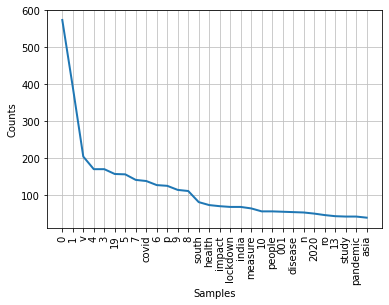

In [17]:
# Here we are plotting the top 30 most recurring words in the document for the president
freqdist_1.plot(30,cumulative=False)

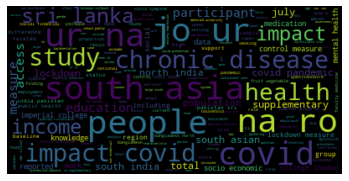

In [18]:
wordcloud = WordCloud(max_font_size=40).generate(' '.join(lemmentized_text))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [19]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe("textrank", last=True)
doc = nlp(cleaned_text)
print("Key-phrases based on rank for the Paper :", Title_Option.value)
for p in doc._.phrases:
    print("{:.4f} {:5d}  {}".format(p.rank, p.count, p.text))
    #print(p.chunks)

Key-phrases based on rank for the Paper : Low uptake of COVID-19 prevention behaviours and high socioeconomic impact of lockdown measures in South Asia: evidence from a large-scale multi-country surveillance programme
0.0623     6  high socioeconomic impact lockdown measures
0.0614     1  south india sri lanka
0.0612     1  south asian health surveillance
0.0612     1  south india
0.0605     1  health south asians
0.0601     1  south asia impact
0.0600     1  south india north india pakistan sri lanka
0.0596     1  north india bangladesh total sri lanka pakistan south india
0.0592     1  south india pakistan
0.0577     1  south asian people
0.0568     1  major adverse impacts pandemic chronic disease treatment mental health health related behaviours employment household finances
0.0544     1  cardiovascular disease south asia low uptake
0.0541     1  india bangladesh future surveillance study
0.0540     1  objective evidence impact control measures
0.0536     1  evidence scale impact s

In [20]:
def get_keywords(text):
  return(keywords(text))
print(get_keywords(cleaned_text))

people
study
studies
measurements
impacted
diabetes
low uptake covid
including
include
includes
disease
india
access
accessed
symptom
supplementary
pandemics
impact lockdown measures south asia evidence large
august
economic impacts
education
educational
educated
reporting
reports
participating
participate
participant
global health research
control
controls
population
populated
populations
work
place measured
medications
medication
increased
increase
increasing
increases
behaviour
restrictive
restricting
diseases reported loss
current
bangladesh
lockdowns implemented march july
supported
incomes
hypertensive diabetic
symptoms transmission
prevention behaviours high
assessed knowledge
working group
national
providing
provided
provide
provides
included closures schools
results participants
non
continuous
continued
services institute medical
effective
effect
pandemic understanding
imperial
public
publication
case
cases
service
country surveillance
currently smoke
worked closely
reopening


Montemurro and Zanette algorithm


The algorithm identifies words that are significant to the structure of the document - these often correspond to the major themes. It does so independently of a corpus.


We used the mz_keywords module from the gensim library that extracts weighted keywords based on the MZ algorithm.

In [21]:
#Getting the weighted Keywords.
def get_weighted_keywords(text):
  return(mz_keywords(' '.join(text), scores=True,weighted=False,threshold=1.0))
get_weighted_keywords(lemmentized_text)

/usr/local/lib/python3.7/dist-packages/gensim/summarization/mz_entropy.py:70: RuntimeWarning: divide by zero encountered in log2
  log_p = numpy.log2(p)
/usr/local/lib/python3.7/dist-packages/gensim/summarization/mz_entropy.py:71: RuntimeWarning: invalid value encountered in multiply
  h = numpy.nan_to_num(p * log_p).sum(axis=0)


[('v', 2.834904210246394),
 ('se', 2.6836093764039584),
 ('ci', 2.5369087960371473),
 ('faculty', 2.5369087960371473),
 ('dark', 2.468325561061426),
 ('st', 2.468325561061426),
 ('q', 2.439265581428128),
 ('rollback', 2.3849977873905512),
 ('containment', 2.292365812774703),
 ('smoker', 2.292365812774703),
 ('entered', 2.2820762766147515),
 ('light', 2.2820762766147515),
 ('stay', 2.2820762766147515),
 ('panel', 2.183230202183467),
 ('answered', 2.1709416162556705),
 ('zone', 2.1546340343530903),
 ('incidence', 2.1523201403243184),
 ('patient', 2.1523201403243184),
 ('yes', 2.044771578293717),
 ('august', 2.0205259126857054),
 ('brac', 1.9924078512743313),
 ('home', 1.9845002103757974),
 ('blue', 1.9843159339037524),
 ('bp', 1.9843159339037524),
 ('cross', 1.9843159339037524),
 ('grant', 1.9843159339037524),
 ('higher', 1.9843159339037524),
 ('james', 1.9843159339037524),
 ('madras', 1.9843159339037524),
 ('mmhg', 1.9843159339037524),
 ('phased', 1.9843159339037524),
 ('sectional', 1.9

In [22]:
def get_NMF_topics(text):
  vectorizer = TfidfVectorizer(max_features=50, min_df=1, stop_words='english')
  X = vectorizer.fit_transform(text)
  idx_to_word = np.array(vectorizer.get_feature_names())
  # apply NMF
  nmf = NMF(n_components=20, solver="mu")
  W = nmf.fit_transform(X)
  H = nmf.components_

  for i, topic in enumerate(H):
      print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word [topic.argsort()[-10:]]])))
get_NMF_topics(lemmentized_text)

Topic 1: diabetes,jo,lockdown,south,impact,11,health,40,covid,19
Topic 2: people,25,supplementary,diabetes,india,12,south,11,jo,covid
Topic 3: high,bangladesh,knowledge,sri,health,supplementary,30,diabetes,40,south
Topic 4: bangladesh,16,control,supplementary,chronic,12,ur,diabetes,20,health
Topic 5: covid,lanka,health,16,knowledge,11,40,chronic,jo,impact
Topic 6: 31,access,social,health,lanka,16,supplementary,chronic,20,lockdown
Topic 7: 15,lanka,impact,non,sri,lockdown,knowledge,diabetes,jo,india
Topic 8: access,16,knowledge,control,supplementary,12,11,chronic,diabetes,measure
Topic 9: 31,15,99,social,16,supplementary,jo,diabetes,20,10
Topic 10: 10,economic,high,29,lanka,non,30,40,ur,people
Topic 11: people,99,lanka,16,knowledge,40,supplementary,30,20,001
Topic 12: people,economic,lanka,high,sri,29,14,ur,40,disease
Topic 13: access,social,bangladesh,behaviour,25,supplementary,14,12,40,2020
Topic 14: pandemic,99,16,high,lanka,29,non,25,jo,ro
Topic 15: people,impact,disease,pandemic,st

[+] Found a total of 1 images in page 0


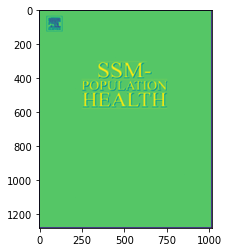

[+] Found a total of 1 images in page 1


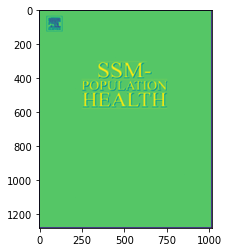

[!] No images found on page 2
[!] No images found on page 3
[!] No images found on page 4
[!] No images found on page 5
[!] No images found on page 6
[!] No images found on page 7
[!] No images found on page 8
[!] No images found on page 9
[!] No images found on page 10
[!] No images found on page 11
[!] No images found on page 12
[!] No images found on page 13
[!] No images found on page 14
[!] No images found on page 15
[!] No images found on page 16
[!] No images found on page 17
[!] No images found on page 18
[!] No images found on page 19
[!] No images found on page 20
[!] No images found on page 21
[!] No images found on page 22
[!] No images found on page 23
[+] Found a total of 4 images in page 24


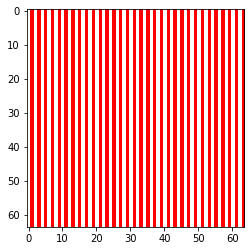

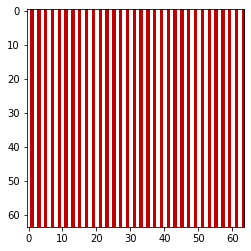

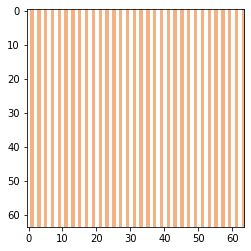

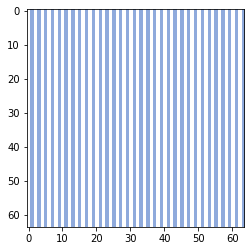

[!] No images found on page 25
[+] Found a total of 2 images in page 26


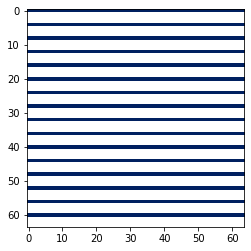

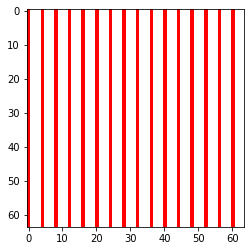

[!] No images found on page 27
[!] No images found on page 28
[!] No images found on page 29
[!] No images found on page 30
[!] No images found on page 31
[!] No images found on page 32
[!] No images found on page 33
[!] No images found on page 34
[!] No images found on page 35
[!] No images found on page 36
[!] No images found on page 37
[!] No images found on page 38
[+] Found a total of 1 images in page 39


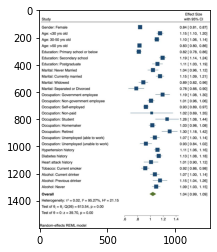

[!] No images found on page 40
[!] No images found on page 41


In [47]:
#Reference:- https://www.thepythoncode.com/article/extract-pdf-images-in-python
#            https://stackoverflow.com/questions/35286540/display-an-image-with-python
image_path="/content/gdrive/My Drive/Data 606/" + key_to_text
# open the file
pdf_file = fitz.open(image_path)
# iterate over PDF pages
for page_index in range(len(pdf_file)):
    # get the page itself
    page = pdf_file[page_index]
    image_list = page.getImageList()
    # printing number of images found in this page
    if image_list:
        print(f"[+] Found a total of {len(image_list)} images in page {page_index}")
    else:
        print("[!] No images found on page", page_index)
    for image_index, img in enumerate(page.getImageList(), start=1):
        # get the XREF of the image
        xref = img[0]
        # extract the image bytes
        base_image = pdf_file.extractImage(xref)
        image_bytes = base_image["image"]
        # get the image extension
        image_ext = base_image["ext"]
        # load it to PIL
        image = Image.open(io.BytesIO(image_bytes))
        imgplot = plt.imshow(image)
        plt.show()
        # save it to local disk
        #image.save(open(f"image{page_index+1}_{image_index}.{image_ext}", "wb"))